In [ ]:
!pip install transformers
!pip install -q hazm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
%matplotlib inline
from transformers import BertTokenizer
from transformers import BertModel
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD

import hazm
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
import random
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
### NEEDED FUNCTION AND CLASSES ###

def generate_dataframe(folder_path):
    files = os.listdir(folder_path)
    poem_files = [f for f in files if f.endswith('.txt')]
    selected_poems = random.sample(poem_files, 10)

    data = pd.DataFrame(columns=['beyt', 'poet'])

    for poem_file in selected_poems:
        df = pd.read_csv(os.path.join(folder_path, poem_file), header=None)
        poet = poem_file.split(".")[0]
        lst = [''] * int(len(df) / 2)
        df_beyt = pd.DataFrame(lst, columns=['beyt'])
        for i in range(int(len(df) / 2)):
            df_beyt.iloc[i] = df.iloc[2 * i] + ' [SEP] ' + df.iloc[2 * i + 1]
        df_beyt['poet'] = poet
        data = pd.concat([data, df_beyt], ignore_index=True, sort=False)
        # Create a LabelEncoder object
        le = LabelEncoder()

          # Fit the LabelEncoder object to the target column
        le.fit(data['poet'])

        # Transform the target column to numerical values
        data['poet_encoded'] = le.transform(data['poet'])
    return data.sample(frac=1).reset_index(drop=True)

class PersianPoemsDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Persian poems corpus. """
    def __init__(self, df):
        poets = data.poet.unique()
        poet_encoded = [data[data.poet == poet].poet_encoded.values[0] for poet in poets]
        poet_dict = dict(zip(poets, poet_encoded))
        self.labels = [poet_dict[label] for label in df['poet']]
        self.texts = [tokenizer(text, padding='max_length', max_length = 35, truncation=True,return_tensors="pt") for text in df['beyt']]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.texts[idx], np.array(self.labels[idx])
ParsBERT = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
class PoemClassifier(nn.Module):
    def __init__(self,is_freeze=True):
        super(PoemClassifier, self).__init__()
        self.bert = ParsBERT
        if is_freeze:
          for param in self.bert.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(768, 10)
    def forward(self, input_ids, attention_mask): 
        return self.fc(self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)[1])

def report_model(model,dataloader,name=''): #confusion matrix , ... 
    y_true = []
    y_pred = []
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
        y_true.extend(labels.tolist())
        y_pred.extend(outputs.argmax(1).tolist())
    print(f'~~~~~~~~~~~~ {name} ~~~~~~~~~~~~ \n')
    print(classification_report(y_true, y_pred, target_names=poets))
    print(f'confusion matrix : \n {confusion_matrix(y_true, y_pred)}')
    print(f'f1_score : {f1_score(y_true, y_pred, average="macro")}')

### perplexity Compartion ##
def perplexity(model1, model2, test_dataloader,criterion):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model1 = model1.cuda()
        model2 = model2.cuda()
    total_loss_model1 = 0
    total_loss_model2 = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output1 = model1(input_id, mask)
            output2 = model2(input_id, mask)
            batch_loss1 = criterion(output1, test_label.long())
            batch_loss2 = criterion(output2, test_label.long())
            total_loss_model1 += batch_loss1.item()
            total_loss_model2 += batch_loss2.item()
    perplexity_model1 = np.exp(total_loss_model1 / len(test_dataloader))
    perplexity_model2 = np.exp(total_loss_model2 / len(test_dataloader))
    return perplexity_model1, perplexity_model2


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# load randomly 10 poems data ###
data = generate_dataframe('./Persian_poems_corpus-master/normalized')
data

,beyt,poet,poet_encoded
0,خور تیغ زن گرچه هرشب زباست [SEP] درین خاک توده...,kamal_norm,7
1,نرگسان رغم مه و پروین را [SEP] شکلی از ماه و پ...,kamal_norm,7
2,سپاهی ز جنگ آوران صدهزار [SEP] نهاده همه سر سو...,ferdousi_norm,2
3,روان مرا پور سامست جفت [SEP] چرا آشکارا بباید ...,ferdousi_norm,2
4,سحر کآید از سر کلکت بود سحر حلال [SEP] بیت کان...,kamal_norm,7
...,...,...,...
199331,ور بود در فقر جان یک ذره چیز [SEP] حال کادالفق...,attar_norm,0
199332,دامن صحبت کشید از چنگ اهل دل فسوس [SEP] ظل رحم...,hatef_norm,5
199333,گر چه غمگین شدم ز واقعه اش [SEP] گشتم الحق ازی...,kamal_norm,7
199334,نماند از سیل اشک من زمین را یک بنا محکم [SEP] ...,helali_norm,6


In [ ]:
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [ ]:
df_train, df_val, df_test = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])
### balance df_train . number of poems from each poet should be equal ### 
df_train = df_train.groupby('poet_encoded').apply(lambda x: x.sample(df_train['poet_encoded'].value_counts().max(), replace=True)).reset_index(drop=True)

## create torch dataloader and dataset ##
train_dataset, val_dataset, test_dataset = PersianPoemsDataset(df_train), PersianPoemsDataset(df_val), PersianPoemsDataset(df_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
# find unique poets in the dataset
poets = data.poet.unique()
poet_encoded = [data[data.poet == poet].poet_encoded.values[0] for poet in poets]
poet_dict = dict(zip(poets, poet_encoded))
poet_dict

{'kamal_norm': 7,
 'ferdousi_norm': 2,
 'attar_norm': 0,
 'saadi_norm': 9,
 'feyz_norm': 3,
 'manoochehri_norm': 8,
 'helali_norm': 6,
 'hafez_norm': 4,
 'babaafzal_norm': 1,
 'hatef_norm': 5}

I choose my poets randomly so my class wa unbalanced ! i use oversampling to balance dataset but please still dont compare accuracy result with others that they select poets how they are balanced!

In [ ]:
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, learning_rate, epochs, criterion, optimizer):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = model.to(device)
    criterion = criterion.to(device)
    total_loss_train_array = []
    total_loss_val_array = []
    total_loss_test_array = []
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            total_acc_val = 0
            total_loss_val = 0
            total_loss_test = 0
            total_acc_test = 0

            for train_input, train_label in tqdm(train_dataloader):
                model.train()
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            ### evalute ### 
            with torch.no_grad():
                for val_input, val_label in val_dataloader:
                    model.eval()
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                for test_input, test_label in test_dataloader:
                    test_label = test_label.to(device)
                    mask = test_input['attention_mask'].to(device)
                    input_id = test_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, test_label.long())
                    total_loss_test += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == test_label).sum().item()
                    total_acc_test += acc
                
            
            print(f"Epoch: {epoch_num+1}/{epochs}")
            print(f"Train Loss: {total_loss_train/len(train_dataloader):.4f} | Train Acc: {total_acc_train/len(train_dataset):.4f}")
            print(f"Val Loss: {total_loss_val/len(val_dataloader):.4f} | Val Acc: {total_acc_val/len(val_dataset):.4f}")
            print(f"Test Loss: {total_loss_test/len(test_dataloader):.4f} | Test Acc: {total_acc_test/len(test_dataset):.4f}")
            print('--------------------------------------')
            total_loss_train_array.append(total_loss_train/len(train_dataloader))
            total_loss_val_array.append(total_loss_val/len(val_dataloader))
            total_loss_test_array.append(total_loss_test/len(test_dataloader))

    ### plot result ###
    plt.title('Loss')
    plt.plot(total_loss_train_array, label='train')
    plt.plot(total_loss_val_array, label='validation')
    plt.plot(total_loss_test_array, label='test')
    plt.legend()
    plt.show() 
    return model,total_loss_train_array,total_loss_test_array,total_loss_val_array



100%|██████████| 23780/23780 [09:52<00:00, 40.16it/s]


Epoch: 1/5
Train Loss: 1.8747 | Train Acc: 0.3449
Val Loss: 1.6063 | Val Acc: 0.4635
Test Loss: 1.6201 | Test Acc: 0.4583
--------------------------------------


100%|██████████| 23780/23780 [09:43<00:00, 40.78it/s]


Epoch: 2/5
Train Loss: 1.7742 | Train Acc: 0.3828
Val Loss: 1.6248 | Val Acc: 0.4524
Test Loss: 1.6380 | Test Acc: 0.4452
--------------------------------------


100%|██████████| 23780/23780 [10:57<00:00, 36.16it/s]


Epoch: 3/5
Train Loss: 1.7478 | Train Acc: 0.3921
Val Loss: 1.5928 | Val Acc: 0.4661
Test Loss: 1.6076 | Test Acc: 0.4589
--------------------------------------


100%|██████████| 23780/23780 [10:53<00:00, 36.37it/s]


Epoch: 4/5
Train Loss: 1.7311 | Train Acc: 0.3990
Val Loss: 1.6091 | Val Acc: 0.4579
Test Loss: 1.6233 | Test Acc: 0.4502
--------------------------------------


100%|██████████| 23780/23780 [11:03<00:00, 35.82it/s]


Epoch: 5/5
Train Loss: 1.7210 | Train Acc: 0.4025
Val Loss: 1.5477 | Val Acc: 0.4812
Test Loss: 1.5625 | Test Acc: 0.4761
--------------------------------------


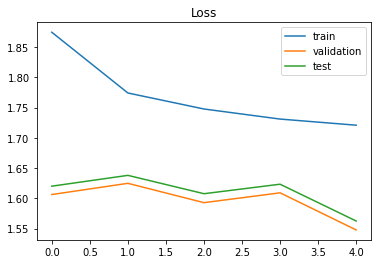

In [ ]:
#### Freeze PRETRAINED WITH ADAM ###
model_freeze_ADAM = PoemClassifier(is_freeze = True)
EPOCHS = 5
LR = 2e-4
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_freeze_ADAM.parameters(), lr= LR)
              
model_freeze_ADAM, total_loss_train_array_freeze_ADAM,total_loss_test_array_freeze_ADAM,total_loss_val_array_freeze_ADAM = train_and_evaluate(model_freeze_ADAM, train_dataloader, val_dataloader, test_dataloader, LR, EPOCHS, criterion, optimizer)
#save model and result
torch.save(model_freeze_ADAM.state_dict(), 'model_freeze_ADAM.pt')
np.save('total_loss_train_array_freeze_ADAM.npy', total_loss_train_array_freeze_ADAM)
np.save('total_loss_test_array_freeze_ADAM.npy', total_loss_test_array_freeze_ADAM)
np.save('total_loss_val_array_freeze_ADAM.npy', total_loss_val_array_freeze_ADAM)


In [ ]:
## confusion matrix , ... ##
report_model(model_freeze_ADAM,test_dataloader, 'Freeze with Adam')

~~~~~~~~~~~~ Freeze with Adam ~~~~~~~~~~~~ 

                  precision    recall  f1-score   support

      kamal_norm       0.89      0.40      0.55      9613
   ferdousi_norm       0.01      0.47      0.03        40
      attar_norm       0.78      0.76      0.77      4890
      saadi_norm       0.23      0.27      0.25       951
       feyz_norm       0.16      0.61      0.25       451
manoochehri_norm       0.05      0.30      0.08       171
     helali_norm       0.10      0.27      0.15       459
      hafez_norm       0.29      0.47      0.36      1551
  babaafzal_norm       0.14      0.42      0.21       236
      hatef_norm       0.33      0.26      0.29      1572

        accuracy                           0.48     19934
       macro avg       0.30      0.42      0.29     19934
    weighted avg       0.69      0.48      0.53     19934

confusion matrix : 
 [[3827  954  753  571  574  490  648 1069  271  456]
 [   5   19    1    2    3    2    2    3    1    2]
 [ 149  107 3

100%|██████████| 23780/23780 [11:04<00:00, 35.76it/s]


Epoch: 1/5
Train Loss: 1.9331 | Train Acc: 0.3239
Val Loss: 1.6928 | Val Acc: 0.4248
Test Loss: 1.7035 | Test Acc: 0.4220
--------------------------------------


100%|██████████| 23780/23780 [11:10<00:00, 35.48it/s]


Epoch: 2/5
Train Loss: 1.8186 | Train Acc: 0.3672
Val Loss: 1.6789 | Val Acc: 0.4262
Test Loss: 1.6918 | Test Acc: 0.4203
--------------------------------------


100%|██████████| 23780/23780 [11:09<00:00, 35.53it/s]


Epoch: 3/5
Train Loss: 1.7841 | Train Acc: 0.3800
Val Loss: 1.5990 | Val Acc: 0.4625
Test Loss: 1.6127 | Test Acc: 0.4572
--------------------------------------


100%|██████████| 23780/23780 [10:13<00:00, 38.75it/s]


Epoch: 4/5
Train Loss: 1.7629 | Train Acc: 0.3878
Val Loss: 1.6035 | Val Acc: 0.4660
Test Loss: 1.6167 | Test Acc: 0.4594
--------------------------------------


100%|██████████| 23780/23780 [11:09<00:00, 35.53it/s]


Epoch: 5/5
Train Loss: 1.7493 | Train Acc: 0.3931
Val Loss: 1.5222 | Val Acc: 0.4906
Test Loss: 1.5343 | Test Acc: 0.4828
--------------------------------------


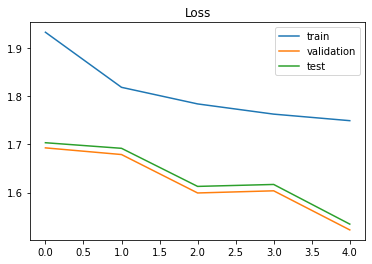

In [ ]:
#### Freeze PRETRAINED WITH SGD ###
model_unfreeze_SGD = PoemClassifier(is_freeze = False)
EPOCHS = 5
LR = 5e-4
criterion = nn.CrossEntropyLoss()
momentum = 0.9
optimizer = SGD(model_unfreeze_SGD.parameters(), lr= LR, momentum = momentum)
model_unfreeze_SGD, total_loss_train_array_freeze_SGD,total_loss_test_array_freeze_SGD,total_loss_val_array_freeze_SGD = train_and_evaluate(model_unfreeze_SGD, train_dataloader, val_dataloader, test_dataloader, LR, EPOCHS, criterion, optimizer)
# save model and result
torch.save(model_unfreeze_SGD.state_dict(), 'model_freeze_SGD.pt')
np.save('total_loss_train_array_freeze_SGD.npy', total_loss_train_array_freeze_SGD)
np.save('total_loss_test_array_freeze_SGD.npy', total_loss_test_array_freeze_SGD)
np.save('total_loss_val_array_freeze_SGD.npy', total_loss_val_array_freeze_SGD)


In [ ]:
## confusion matrix , ... ##
report_model(model_unfreeze_SGD,test_dataloader,'unFreeze with SGD')

~~~~~~~~~~~~ unFreeze with SGD ~~~~~~~~~~~~ 

                  precision    recall  f1-score   support

      kamal_norm       0.87      0.44      0.58      9613
   ferdousi_norm       0.01      0.62      0.02        40
      attar_norm       0.77      0.74      0.75      4890
      saadi_norm       0.24      0.30      0.27       951
       feyz_norm       0.24      0.39      0.30       451
manoochehri_norm       0.07      0.18      0.10       171
     helali_norm       0.10      0.38      0.15       459
      hafez_norm       0.34      0.34      0.34      1551
  babaafzal_norm       0.10      0.53      0.18       236
      hatef_norm       0.34      0.28      0.31      1572

        accuracy                           0.48     19934
       macro avg       0.31      0.42      0.30     19934
    weighted avg       0.68      0.48      0.54     19934

confusion matrix : 
 [[4223 1288  760  598  191  181  888  610  445  429]
 [   4   25    0    2    0    2    1    0    2    4]
 [ 213  192 

100%|██████████| 23780/23780 [11:18<00:00, 35.06it/s]


Epoch: 1/5
Train Loss: 1.8271 | Train Acc: 0.3598
Val Loss: 1.6406 | Val Acc: 0.4412
Test Loss: 1.6547 | Test Acc: 0.4329
--------------------------------------


100%|██████████| 23780/23780 [11:21<00:00, 34.91it/s]


Epoch: 2/5
Train Loss: 1.7455 | Train Acc: 0.3917
Val Loss: 1.6578 | Val Acc: 0.4361
Test Loss: 1.6729 | Test Acc: 0.4307
--------------------------------------


100%|██████████| 23780/23780 [11:01<00:00, 35.95it/s]


Epoch: 3/5
Train Loss: 1.7246 | Train Acc: 0.3998
Val Loss: 1.4808 | Val Acc: 0.5085
Test Loss: 1.4946 | Test Acc: 0.5059
--------------------------------------


100%|██████████| 23780/23780 [11:17<00:00, 35.08it/s]


Epoch: 4/5
Train Loss: 1.7129 | Train Acc: 0.4038
Val Loss: 1.4413 | Val Acc: 0.5085
Test Loss: 1.4564 | Test Acc: 0.4997
--------------------------------------


100%|██████████| 23780/23780 [11:18<00:00, 35.04it/s]


Epoch: 5/5
Train Loss: 1.7058 | Train Acc: 0.4062
Val Loss: 1.6503 | Val Acc: 0.4380
Test Loss: 1.6674 | Test Acc: 0.4322
--------------------------------------


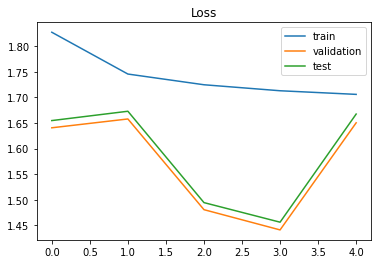

In [ ]:
#### Fine_tune_ADAM PRETRAINED WITH ADAM ###
model_unfreeze_ADAM = PoemClassifier(is_freeze = False)
EPOCHS = 5
LR = 5e-4 
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_unfreeze_ADAM.parameters(), lr= LR)
              
model_unfreeze_ADAM, total_loss_train_array_unfreeze_ADAM,total_loss_test_array_unfreeze_ADAM,total_loss_val_array_unfreeze_ADAM = train_and_evaluate(model_unfreeze_ADAM, train_dataloader, val_dataloader, test_dataloader, LR, EPOCHS, criterion, optimizer)
# save model and result
torch.save(model_unfreeze_ADAM.state_dict(), 'model_unfreeze_ADAM.pt')
np.save('total_loss_train_array_unfreeze_ADAM.npy', total_loss_train_array_unfreeze_ADAM)
np.save('total_loss_test_array_unfreeze_ADAM.npy', total_loss_test_array_unfreeze_ADAM)
np.save('total_loss_val_array_unfreeze_ADAM.npy', total_loss_val_array_unfreeze_ADAM)


**it is abvious that with appropriate LR , unfreeze bert will learn better because it has more parameters . it happen hear too but their difference i think could be more ! i should check more different learning rate (as i did for freeze model before running) but deadline was here ! :))**

In [ ]:
## confusion matrix , ... ##
report_model(model_unfreeze_ADAM,test_dataloader,'unFreeze with ADAM')

~~~~~~~~~~~~ unFreeze with ADAM ~~~~~~~~~~~~ 

                  precision    recall  f1-score   support

      kamal_norm       0.93      0.28      0.43      9613
   ferdousi_norm       0.01      0.57      0.02        40
      attar_norm       0.76      0.78      0.77      4890
      saadi_norm       0.24      0.28      0.26       951
       feyz_norm       0.18      0.56      0.27       451
manoochehri_norm       0.06      0.22      0.09       171
     helali_norm       0.14      0.15      0.14       459
      hafez_norm       0.24      0.57      0.33      1551
  babaafzal_norm       0.10      0.53      0.17       236
      hatef_norm       0.31      0.30      0.30      1572

        accuracy                           0.43     19934
       macro avg       0.30      0.42      0.28     19934
    weighted avg       0.70      0.43      0.47     19934

confusion matrix : 
 [[2686 1361  918  617  464  285  275 1825  532  650]
 [   2   23    0    1    4    1    0    5    2    2]
 [  57  131

In [ ]:
criterion = nn.CrossEntropyLoss()
perplexity1, perplexity2 = perplexity(model_freeze_ADAM, model_unfreeze_ADAM, test_dataloader,criterion)
print(f"Before Fine-tuning: {perplexity1:>0.4f}")  
print(f"After Fine-tuning: {perplexity2:>0.4f}")  


Before Fine-tuning: 5.3417
After Fine-tuning: 5.2274
